# Lab 2 Användning av Keras CNN på MNIST


In [23]:
from PIL import Image, ImageFilter
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import Callback
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.datasets import mnist
from keras.optimizers import RMSprop
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.cm
import numpy as np
import sys
import keras

threads = 12
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': threads}) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 1
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

Två hjälpfunktioner för att visa bilder och lite text på ett rutnät

In [24]:
def formatSquareGrid(grid, trueClass, predictedClass):
    if len(np.shape(trueClass)) == 2: #check if one-hot encoded 2 dim arrays
        trueClass = np.where(trueClass > 0)[1]
    if len(np.shape(predictedClass)) == 2: #check if one-hot encoded 2 dim arrays
        predictedClass = np.where(predictedClass > 0)[1]
    for i in range(len(grid[0])):
        for j in range(len(grid[1])):
            grid[i,j].axis('off')
            grid[i,j].set_title('True: ' + str(trueClass[len(grid[1])*i + j]) + ' Pred: ' + str(predictedClass[len(grid[1])*i + j]))

def drawSquareGrid(grid, displayData):
    cmap = matplotlib.cm.get_cmap('gray') # set to grayscale
    if len(displayData.shape)==2: # Assume data flattened from square images
        displayData = displayData.reshape(displayData.shape[0], int(np.sqrt(displayData.shape[1])), int(np.sqrt(displayData.shape[1])))
    if len(displayData.shape) == 4: # Assume 4-dim tensor with one layer of intensity
        displayData = np.squeeze(displayData, axis=3)
    for i in range(len(grid[0])):
        for j in range(len(grid[1])):
            if np.array(displayData[len(grid[1])*i + j]).max() > 0 :
                scale_factor = 255.0*(1.0/np.array(displayData[len(grid[1])*i + j]).max())
            grayscaleImage = cmap((scale_factor*(np.array(displayData[len(grid[1])*i + j]).max()-np.array(displayData[len(grid[1])*i + j]))).astype(int))
            grid[i,j].imshow(grayscaleImage)

Ladda data från MNIST och formattera layout för att passa faltningsfiltren

In [25]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

img_rows, img_cols = x_train[0].shape

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Konvertera till one-hot, exempel "5" -> "[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"

In [26]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Visa 3x3 bilder av MNIST

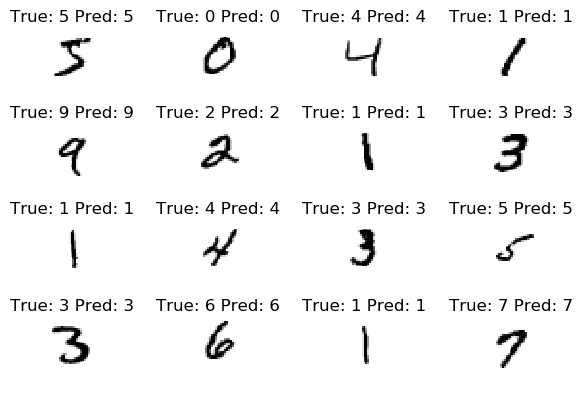

In [27]:
fig, grid = plt.subplots(nrows=4, ncols=4, dpi=100)
fig.tight_layout()
idxs = np.array(range(len(grid[0])*len(grid[1])))

formatSquareGrid(grid = grid, trueClass = y_train[idxs], predictedClass = y_train[idxs])
drawSquareGrid(grid = grid, displayData = x_train[idxs])

Lägg till en sekventiell modell

In [28]:
model = Sequential()

Lägg till ett antal lager

In [29]:
print(input_shape)
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

(28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0        

En en överskuggad callbackklass för modellanpassningen

In [30]:
class ModelDataCallback(Callback):
    def __init__(self):
        super().__init__
        
    def on_epoch_end(self, batch, logs):
        super().on_epoch_end(batch, logs)
        
    def on_batch_begin(self, batch, logs):
        super().on_batch_begin(batch, logs)
    
    def on_batch_end(self, batch, logs):
        super().on_batch_end(batch, logs)

Några konstanter

In [31]:
batch_size = 512
epochs = 12

Kompilera den sekventiella modellen för en multikategori klassificering

In [32]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Anpassa modellen med en callbackinstans

In [33]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test),callbacks=[ModelDataCallback()])

In [34]:
score = model.evaluate(x_test, y_test, verbose=0)
print(score)

[0.034907580469202365, 0.9883]


Prediktera/klassificera på testvektorn

In [35]:
predictions = model.predict(x_test)

Gör en prediktion på den mest sannolika siffran

In [36]:
predictedNumber = np.where(predictions == predictions.max(axis=1)[:,None])[1]
print(predictedNumber)

[7 2 1 ... 4 5 6]


Gör siffran till en one-hot vektor

In [37]:
oneHotPredictedNumber = keras.utils.to_categorical(predictedNumber, 10)
print(oneHotPredictedNumber[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Den sanna siffran

In [38]:
trueNumber = np.where(y_test == y_test.max(axis=1)[:,None])[1]
print(trueNumber)

[7 2 1 ... 4 5 6]


Hitta korrekta klassificeringar

In [39]:
classificationSuccess = np.equal(predictedNumber, trueNumber)
trueNumbers = trueNumber[classificationSuccess]
predictedNumbers = predictedNumber[classificationSuccess]
classifiedImages = x_test[classificationSuccess]

Visa korrekta klassificeringar

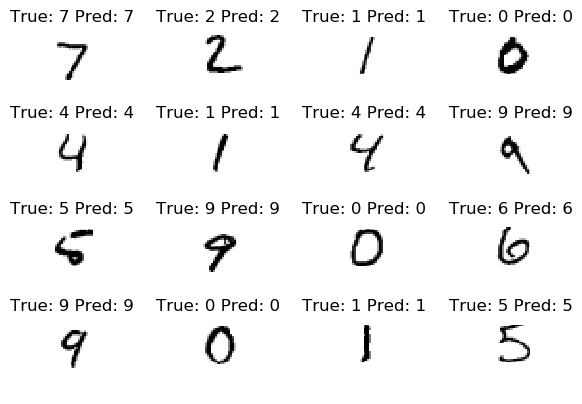

In [40]:
fig2, grid2 = plt.subplots(nrows=4, ncols=4, dpi=100)
fig2.tight_layout()
idxs2 = np.array(range(len(grid2[0])*len(grid2[1])))
formatSquareGrid(grid = grid2, trueClass = trueNumbers[idxs2], predictedClass = predictedNumbers[idxs2])
drawSquareGrid(grid = grid2, displayData = classifiedImages[idxs2])

Hitta felaktiga klassificeringar:

In [41]:
classificationErrors = np.not_equal(predictedNumber, trueNumber)
trueNumbers = trueNumber[classificationErrors]
predictedNumbers = predictedNumber[classificationErrors]
classifiedImages = x_test[classificationErrors]

Visa felaktiga klassificeringar

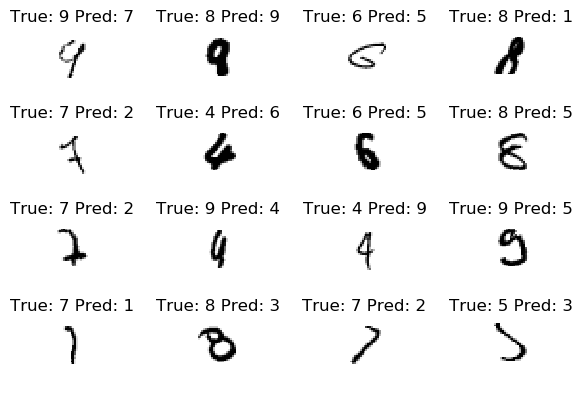

In [42]:
fig3, grid3 = plt.subplots(nrows=4, ncols=4, dpi=100)
fig3.tight_layout()
idxs3 = 10+np.array(range(len(grid2[0])*len(grid2[1])))
formatSquareGrid(grid = grid3, trueClass = trueNumbers[idxs3], predictedClass = predictedNumbers[idxs3])
drawSquareGrid(grid = grid3, displayData = classifiedImages[idxs3])